In [8]:
import matplotlib.pyplot as plt
import pandas as pd

from src.etl.utils import download_data_from_uciml, load_data

In [15]:
from IPython.display import display, HTML
js = "<script>$('.output_scroll').removeClass('output_scroll')</script>"
display(HTML(js))

In [9]:
download_data_from_uciml(id=544)
X, y = load_data()

In [10]:
print(X.shape, y.shape)

(2111, 16) (2111,)


In [11]:
X.dtypes

Gender                             object
Age                               float64
Height                            float64
Weight                            float64
family_history_with_overweight     object
FAVC                               object
FCVC                              float64
NCP                               float64
CAEC                               object
SMOKE                              object
CH2O                              float64
SCC                                object
FAF                               float64
TUE                               float64
CALC                               object
MTRANS                             object
dtype: object

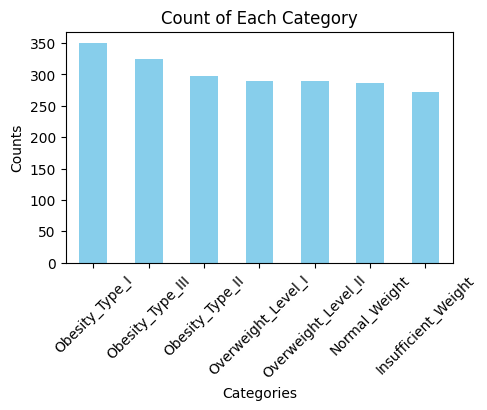

In [12]:
plot_df = y.value_counts()

plt.figure(figsize=(5, 3))
plot_df.plot(kind='bar', color='skyblue')
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.title('Count of Each Category')
plt.xticks(rotation=45)
plt.show()

In [13]:
import ast
[print(f"Missing data for {data}: \n {globals()[data].isna().sum()}") for data in ["y", "X"]]

Missing data for y: 
 0
Missing data for X: 
 Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
dtype: int64


[None, None]

In [16]:
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from sklearn.model_selection import KFold

In [17]:
def preprocess_data(X, y):
    """
    Preprocess the dataset: Encode categorical variables, normalize numerical variables, and convert to PyTorch tensors.

    Parameters:
    X (DataFrame): The feature dataset.
    y (Series): The target variable.

    
    Returns:
    X (Tensor): The preprocessed features as a tensor
    y (Tensor): The preprocessed target variable as a tensor
    """
    categorical_features = X.select_dtypes(include=['object']).columns
    numeric_features = X.select_dtypes(include=['float64']).columns
    
    y = pd.get_dummies(y).values

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(), categorical_features)])

    X = preprocessor.fit_transform(X)
    X, y = [torch.tensor(z, dtype=torch.float32) for z in [X, y]]
    return X, y

In [18]:
def train_validate_model(model, criterion, optimizer, train_loader, val_loader, epochs: int):
    """
    Train and validate the PyTorch model, returning the history of training and validation losses.

    Parameters:
    model (torch.nn.Module): The model to be trained and validated
    criterion (Callable): Loss function
    optimizer (torch.optim.Optimizer): Optimizer
    train_loader (DataLoader): DataLoader for the training set
    val_loader (DataLoader): DataLoader for the validation set
    epochs (int): Number of training epochs

    Returns:
    Tuple[List[float], List[float]]: Lists of average training and validation losses per epoch
    """
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, torch.max(labels, 1)[1])
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, torch.max(labels, 1)[1])
                total_val_loss += loss.item()
        
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

    return train_losses, val_losses


def evaluate_model(model, test_loader):
    """
    Evaluate the PyTorch model.

    Parameters:
    model: The PyTorch model to be evaluated
    test_loader: DataLoader for the test set

    Returns:
    accuracy (float): The accuracy of the model on the test set
    """
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == torch.max(labels, 1)[1]).sum().item()

    accuracy = 100 * correct / total
    return accuracy

In [19]:
from typing import Callable, List

def perform_cross_validation(model_factory: Callable[[int, int], torch.nn.Module], 
                             optimizer_factory: Callable[[torch.nn.Module], torch.optim.Optimizer],
                             X: torch.Tensor, 
                             y: torch.Tensor, 
                             k_folds: int,
                             epochs: int = 70) -> List[float]:
    """
    Perform k-fold cross-validation and return average test accuracy, training losses, and validation losses.

    Parameters:
    model_factory (Callable[[int, int], torch.nn.Module]): Factory function to create a new instance of the model
    optimizer_factory (Callable[[torch.nn.Module], torch.optim.Optimizer]): Factory function to create a new optimizer
    X (torch.Tensor): The features
    y (torch.Tensor): The target variable
    k_folds (int): Number of folds in cross-validation

    Returns:
    Tuple[float, List[List[float]], List[List[float]]]: Average accuracy, training losses, validation losses
    """
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    fold_accuracies = []
    all_train_losses, all_val_losses = [], []

    for fold, (train_ids, test_ids) in enumerate(kfold.split(X)):
        # Split data for the fold
        X_train, X_test = X[train_ids], X[test_ids]
        y_train, y_test = y[train_ids], y[test_ids]

        # DataLoaders
        train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
        val_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=32)
        test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=32)
        
        # Determine input and output sizes
        input_size = X_train.shape[1]
        output_size = y_train.shape[1] # assuming y_train is one-hot encoded

        # Initialize model for the current fold
        model = model_factory(input_size, output_size)
        criterion = nn.CrossEntropyLoss()
        optimizer = optimizer_factory(model)
            
        train_losses, val_losses = train_validate_model(model, criterion, optimizer, train_loader, val_loader, epochs)
        all_train_losses.append(train_losses)
        all_val_losses.append(val_losses)

        fold_accuracy = evaluate_model(model, test_loader)
        print(f'Fold {fold+1}, Accuracy: {fold_accuracy}%')
        fold_accuracies.append(fold_accuracy)
        
    avg_accuracy = np.mean(fold_accuracies)
    return avg_accuracy, all_train_losses, all_val_losses

In [20]:
def plot_train_val_losses(train_losses, val_losses, opti: str, model: str, save: bool = False):
    """
    Plot the training and validation loss curves.

    Parameters:
    train_losses (List[List[float]]): Training losses for each fold
    val_losses (List[List[float]]): Validation losses for each fold
    """
    avg_train_losses = np.mean(train_losses, axis=0)
    avg_val_losses = np.mean(val_losses, axis=0)

    plt.figure(figsize=(10, 6))
    plt.plot(avg_train_losses, label='Average Training Loss')
    plt.plot(avg_val_losses, label='Average Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss Curves for {model} with {opti} optimizer')
    plt.legend()
    if save:
        plt.savefig(f'../assets/img/curves_{model}_{opti.lower()}.png')
    plt.show()

In [39]:
adam_grid = {
    'lr': [0.001, 0.0005, 0.0001, 0.00005],
    'betas': [(0.9, 0.999), (0.95, 0.999), (0.85, 0.995)]
}

sgd_grid = {
    'lr': [0.01, 0.005, 0.001, 0.0005],
    'momentum': [0.95, 0.9, 0.8],
    'nesterov': [True]
}

adagrad_grid = {
    'lr': [0.01, 0.005, 0.001, 0.0005]
}

rmsprop_grid = {
    'lr': [0.01, 0.001, 0.0001],
    'alpha': [0.99, 0.9],
    'momentum': [0.95, 0.9, 0.8]
}

In [40]:
from itertools import product

def grid_search_optimizer(model_factory, optimizer_factory, param_grid, X, y, k_folds=5, epochs=70):
    best_accuracy = 0
    best_params = None

    for params in product(*param_grid.values()):
        # Set the parameters for the optimizer
        optimizer_params = dict(zip(param_grid.keys(), params))
        optimizer = lambda model: optimizer_factory(model, **optimizer_params)

        # Perform cross-validation
        avg_accuracy, _, _ = perform_cross_validation(model_factory, optimizer, X, y, k_folds, epochs)

        if avg_accuracy > best_accuracy:
            best_accuracy = avg_accuracy
            best_params = optimizer_params

        print(f"Params: {optimizer_params}, Accuracy: {avg_accuracy:.2f}%")

    return best_params, best_accuracy

def adam_factory(model, lr, betas):
    return optim.Adam(model.parameters(), lr=lr, betas=betas)

def sgd_nesterov_factory(model, lr, momentum, nesterov=True):
    return optim.SGD(model.parameters(), lr=lr, momentum=momentum, nesterov=nesterov)

def adagrad_factory(model, lr):
    return optim.Adagrad(model.parameters(), lr=lr)

def rmsprop_factory(model, lr, alpha):
    return torch.optim.RMSprop(model.parameters(), lr=lr, alpha=alpha)

In [41]:
class LogisticRegression(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        out = self.linear(x)
        return out
    
class SimpleNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, num_classes)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
class ComplexNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(ComplexNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(64, 32)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(32, num_classes)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu2(self.fc2(x))
        x = self.dropout2(x)
        x = self.relu3(self.fc3(x))
        x = self.fc4(x)
        return x
    
logistic_regression_factory = lambda input_size, output_size: LogisticRegression(input_size, output_size)
simple_nn_factory = lambda input_size, output_size: SimpleNN(input_size, output_size)
complex_nn_factory = lambda input_size, output_size: ComplexNN(input_size, output_size)

models = {
    'Logistic Regression': logistic_regression_factory,
    'Simple Neural Network': simple_nn_factory,
    'Complex Neural Network': complex_nn_factory
}

In [42]:
import matplotlib.pyplot as plt
import numpy as np

def plot_optimizer_losses(model_name, optimizer_losses, save=False):
    """
    Plot the training and validation loss curves for different optimizers side by side.

    Parameters:
    model_name (str): Name of the model
    optimizer_losses (dict): A dictionary where keys are optimizer names and values are tuples of (train_losses, val_losses)
    save (bool): Whether to save the plot
    """
    num_optimizers = len(optimizer_losses)
    fig, axes = plt.subplots(1, num_optimizers, figsize=(num_optimizers * 6, 5), sharey=True)

    for idx, (opti, (train_losses, val_losses)) in enumerate(optimizer_losses.items()):
        avg_train_losses = np.mean(train_losses, axis=0)
        avg_val_losses = np.mean(val_losses, axis=0)

        ax = axes[idx]
        ax.plot(avg_train_losses, label='Average Training Loss')
        ax.plot(avg_val_losses, label='Average Validation Loss')
        ax.set_title(f'{opti} Optimizer')
        ax.set_xlabel('Epochs')
        if idx == 0:
            ax.set_ylabel('Loss')
        ax.legend()

    plt.suptitle(f'Training and Validation Loss Curves for {model_name.lower().replace(" ", "_")}')
    
    if save:
        plt.savefig(f'../assets/img/loss_curves_{model_name}.png')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [43]:
X_preprocessed, y_preprocessed = preprocess_data(X, y)

optimizers = {
    'Adam': (adam_factory, adam_grid),
    'SGD_Nesterov': (sgd_nesterov_factory, sgd_grid),
    'AdaGrad': (adagrad_factory, adagrad_grid),
    'RMSProp': (rmsprop_factory, rmsprop_grid)
}

for model_name, model_factory in models.items():
    optimizer_losses = {}
    for opt_name, (opt_factory, opt_grid) in tqdm(optimizers.items()):
        print(f"\nRunning grid search for {model_name} with {opt_name}")
        
        # Perform grid search
        best_params, best_accuracy = grid_search_optimizer(
            model_factory, opt_factory, opt_grid, X_preprocessed, y_preprocessed, k_folds=5, epochs=120
        )
        print(f"Best parameters for {model_name} using {opt_name}: {best_params}, Best Accuracy: {best_accuracy}%")

        # Train with best parameters
        optimized_optimizer_factory = lambda model: opt_factory(model, **best_params)
        print(f"\nTraining {model_name} with {opt_name} using best parameters")
        avg_accuracy, all_train_losses, all_val_losses = perform_cross_validation(
            model_factory, optimized_optimizer_factory, X_preprocessed, y_preprocessed, k_folds=15, epochs=120
        )

        #lot_train_val_losses(all_train_losses, all_val_losses, model=model_name, opti=opt_name, save=True)
        # Collect losses for plotting
        optimizer_losses[opt_name] = (all_train_losses, all_val_losses)
        
        print(f'Average Cross-Validation Accuracy: {round(avg_accuracy, 2)}%')
        
    # Plot losses for all optimizers of the current model
    plot_optimizer_losses(model_name, optimizer_losses, save=True)

  0%|          | 0/4 [00:00<?, ?it/s]


Running grid search for Logistic Regression with Adam
Fold 1, Accuracy: 75.65011820330969%
Fold 2, Accuracy: 80.33175355450237%
Fold 3, Accuracy: 76.77725118483413%
Fold 4, Accuracy: 74.17061611374407%
Fold 5, Accuracy: 78.43601895734596%
Params: {'lr': 0.001, 'betas': (0.9, 0.999)}, Accuracy: 77.07%
Fold 1, Accuracy: 75.177304964539%
Fold 2, Accuracy: 80.56872037914692%
Fold 3, Accuracy: 77.01421800947867%
Fold 4, Accuracy: 74.40758293838863%
Fold 5, Accuracy: 78.90995260663507%
Params: {'lr': 0.001, 'betas': (0.95, 0.999)}, Accuracy: 77.22%
Fold 1, Accuracy: 77.06855791962175%
Fold 2, Accuracy: 80.80568720379146%
Fold 3, Accuracy: 77.72511848341232%
Fold 4, Accuracy: 74.88151658767772%
Fold 5, Accuracy: 80.09478672985782%
Params: {'lr': 0.001, 'betas': (0.85, 0.995)}, Accuracy: 78.12%
Fold 1, Accuracy: 70.2127659574468%
Fold 2, Accuracy: 76.06635071090048%
Fold 3, Accuracy: 70.61611374407583%
Fold 4, Accuracy: 70.85308056872037%
Fold 5, Accuracy: 72.74881516587678%
Params: {'lr': 0.

 25%|██▌       | 1/4 [02:59<08:57, 179.24s/it]

Fold 15, Accuracy: 79.28571428571429%
Average Cross-Validation Accuracy: 79.59%

Running grid search for Logistic Regression with SGD_Nesterov
Fold 1, Accuracy: 87.70685579196217%
Fold 2, Accuracy: 90.04739336492891%
Fold 3, Accuracy: 88.86255924170617%
Fold 4, Accuracy: 87.44075829383887%
Fold 5, Accuracy: 90.99526066350711%
Params: {'lr': 0.01, 'momentum': 0.95, 'nesterov': True}, Accuracy: 89.01%
Fold 1, Accuracy: 84.86997635933807%
Fold 2, Accuracy: 88.86255924170617%
Fold 3, Accuracy: 85.07109004739337%
Fold 4, Accuracy: 84.12322274881517%
Fold 5, Accuracy: 89.0995260663507%
Params: {'lr': 0.01, 'momentum': 0.9, 'nesterov': True}, Accuracy: 86.41%
Fold 1, Accuracy: 82.50591016548464%
Fold 2, Accuracy: 86.49289099526067%
Fold 3, Accuracy: 81.75355450236967%
Fold 4, Accuracy: 79.38388625592417%
Fold 5, Accuracy: 85.54502369668246%
Params: {'lr': 0.01, 'momentum': 0.8, 'nesterov': True}, Accuracy: 83.14%
Fold 1, Accuracy: 85.81560283687944%
Fold 2, Accuracy: 88.15165876777252%
Fold 3

 50%|█████     | 2/4 [05:41<05:38, 169.31s/it]

Fold 15, Accuracy: 92.14285714285714%
Average Cross-Validation Accuracy: 89.68%

Running grid search for Logistic Regression with AdaGrad
Fold 1, Accuracy: 66.903073286052%
Fold 2, Accuracy: 68.00947867298578%
Fold 3, Accuracy: 61.84834123222749%
Fold 4, Accuracy: 64.92890995260663%
Fold 5, Accuracy: 68.00947867298578%
Params: {'lr': 0.01}, Accuracy: 65.94%
Fold 1, Accuracy: 62.88416075650118%


 50%|█████     | 2/4 [05:57<05:57, 178.77s/it]


KeyboardInterrupt: 